In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

In [2]:
import math
import time

import librosa
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio, display


DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = "sinc_interpolation"


def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

    offset is used to avoid negative infinity `log(offset + x)`.

    """
    # 起始位置是log(offset) 结束位置是log(offset + 最大扫描频率//2)
    # 取log -> 取delta -> exp 这样就使得
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    print('start: ', start)
    print('stop: ', stop)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset
    # linspace产生从start到stop的 sample_rate个点的值
    # 再取指数就变成了[0, max_sweep_rate // 2] 总共sample_rate个点
    # 由于sample_rate和sweep_rate相等 所以最大的freq是 sample_rate//2


def _get_inverse_log_freq(freq, sample_rate, offset):
    """Find the time where the given frequency is given by _get_log_freq"""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))


def _get_freq_ticks(sample_rate, offset, f_max):
    # Given the original sample rate used for generating the sweep,
    # find the x-axis value where the log-scale major frequency values fall in
    time, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10 ** exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                time.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    time.append(t_max)
    freq.append(f_max)
    return time, freq


def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    print('freq: ', freq)
    print('freq_shape: ', freq.shape)
    delta = 2 * math.pi * freq / sample_rate
    # freq[0, sample_rate/2] 那么delta就是[0, pi]
    print('delta: ', delta)
    print('delta_shape: ', delta.shape)
    cummulative = torch.cumsum(delta, dim=0)
    print('cummulative: ', cummulative)
    print('cummulative_shape: ', cummulative.shape)
    # 累加是什么意思呢
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal


def plot_sweep(
    waveform,
    sample_rate,
    title,
    max_sweep_rate=SWEEP_MAX_SAMPLE_RATE,
    offset=DEFAULT_OFFSET,
):
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.show(block=True)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=DEFAULT_LOWPASS_FILTER_WIDTH,
    rolloff=DEFAULT_ROLLOFF,
    resampling_method=DEFAULT_RESAMPLING_METHOD,
    beta=None,
    librosa_type=None,
    iters=5,
):
    if method == "functional":
        begin = time.time()
        for _ in range(iters):
            F.resample(
                waveform,
                sample_rate,
                resample_rate,
                lowpass_filter_width=lowpass_filter_width,
                rolloff=rolloff,
                resampling_method=resampling_method,
            )
        elapsed = time.time() - begin
        return elapsed / iters
    elif method == "transforms":
        resampler = T.Resample(
            sample_rate,
            resample_rate,
            lowpass_filter_width=lowpass_filter_width,
            rolloff=rolloff,
            resampling_method=resampling_method,
            dtype=waveform.dtype,
        )
        begin = time.time()
        for _ in range(iters):
            resampler(waveform)
        elapsed = time.time() - begin
        return elapsed / iters
    elif method == "librosa":
        waveform_np = waveform.squeeze().numpy()
        begin = time.time()
        for _ in range(iters):
            librosa.resample(waveform_np, orig_sr=sample_rate, target_sr=resample_rate, res_type=librosa_type)
        elapsed = time.time() - begin
        return elapsed / iters

In [3]:
sample_rate = 48000
resample_rate = 32000
# 采样率就是一秒采样多少个点

In [4]:
waveform = get_sine_sweep(sample_rate)
waveform.shape

start:  5.303304908059076
stop:  10.094149233605084
freq:  tensor([0.0000e+00, 2.0063e-02, 4.0128e-02,  ..., 2.3995e+04, 2.3998e+04,
        2.4000e+04], dtype=torch.float64)
freq_shape:  torch.Size([48000])
delta:  tensor([0.0000e+00, 2.6263e-06, 5.2528e-06,  ..., 3.1410e+00, 3.1413e+00,
        3.1416e+00], dtype=torch.float64)
delta_shape:  torch.Size([48000])
cummulative:  tensor([0.0000e+00, 2.6263e-06, 7.8790e-06,  ..., 3.0208e+04, 3.0211e+04,
        3.0214e+04], dtype=torch.float64)
cummulative_shape:  torch.Size([48000])


torch.Size([1, 48000])

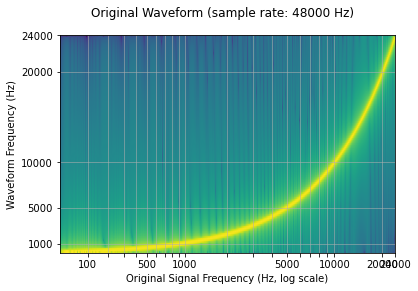

In [5]:
plot_sweep(waveform, sample_rate, title='Original Waveform')

In [6]:
play_audio(waveform, sample_rate)

In [7]:
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
# T.Resample是一个从sample_rate到resample_rate的对象

In [8]:
resampled_waveform = resampler(waveform)
resampled_waveform.shape

torch.Size([1, 32000])

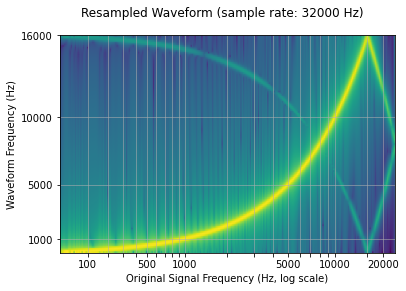

In [9]:
plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")

In [10]:
play_audio(waveform, sample_rate)

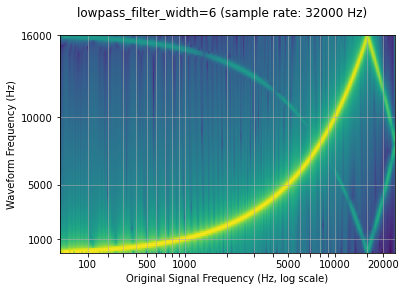

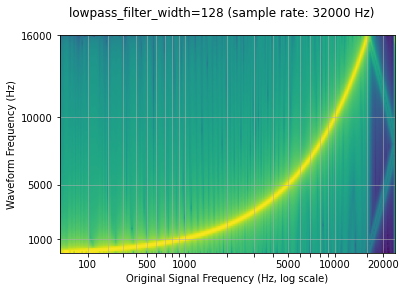

In [11]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=6")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=128")

# 设置不同的低通滤波宽度

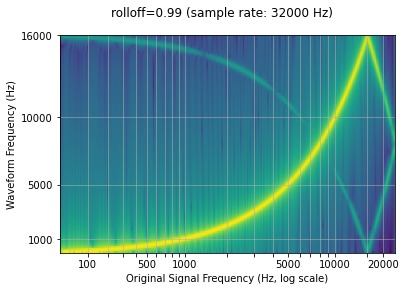

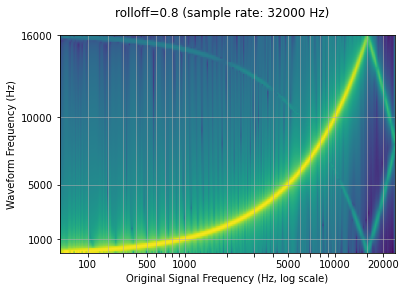

In [12]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.99")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.8")

# 奈奎斯特频率（Nyquist frequency）-> rolloff参数

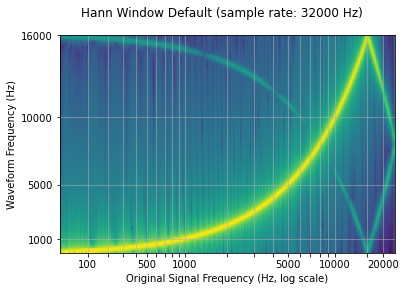

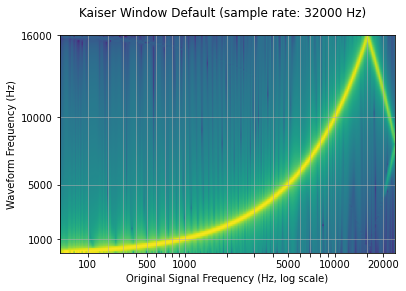

In [13]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
plot_sweep(resampled_waveform, resample_rate, title="Hann Window Default")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="kaiser_window")
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Default")

重采样的核心就是用另一个采样率作用在波上 方法有很多 参数也有很多 根据不同的情况进行选择
对于重采样来说 声音的时间时不变的 采样率的改变只是在一秒钟采样的点的个数的改变
采样率增大 一秒内的数据点个数增加 音频质量升高 否则降低